# CRAWL STOCK API

## Nguồn dữ liệu: DStock, FireAnt, VietStock Finance

### 1. Chuẩn bị dữ liệu

Import các thư viện cần thiết cho việc thu thập dữ liệu.

In [1]:
import requests
import pandas as pd

Lấy thông tin các công ty đã từng được đưa lên sàn chứng khoán Việt Nam

In [2]:
def get_stock_list():
    VNDIRECT_API = 'https://finfo-api.vndirect.com.vn/v4/stocks'
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
        'Content-Type': 'application/json',
    }
    
    params = {
        "q": "type:stock,ifc~floor:HOSE,HNX,UPCOM",
        "size": "9999"
    }
    
    response = requests.get(url = VNDIRECT_API, params = params, headers = headers)
    
    if response.status_code == 200:
        field_to_get = ["code", "type", "status", "companyName", "listedDate", "delistedDate"]
        df = pd.DataFrame(response.json()["data"])
        df = df[field_to_get]
        return pd.DataFrame(df)
        
    return []

In [3]:
stock_data = get_stock_list()
stock_data.head()

,code,type,status,companyName,listedDate,delistedDate
0,ENF,IFC,delisted,Quỹ Đầu tư Năng động Eastspring Investments Vi...,2001-01-01,2001-01-01
1,FUCVREIT,IFC,listed,Quỹ đầu tư bất động sản Techcom Việt Nam,2017-02-27,NaN
2,FUCTVGF3,IFC,listed,Quỹ đầu tư tăng trưởng Thiên Việt 3,2021-10-27,NaN
3,FUCTVGF1,IFC,delisted,Quỹ đầu tư tăng trưởng TVAM,2016-12-22,2021-05-04
4,VFMVF4,IFC,delisted,Quỹ đầu tư Doanh nghiệp hàng đầu Việt Nam,2008-06-12,2013-11-26


Data clean up

In [4]:
import re

def cleanRoman(text):
    pattern = r'\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?'
    return re.sub(pattern, '', text)

def cleanText(text):
    pattern = r'[^A-Za-z]+'
    return re.sub(pattern, '', text)

def cleanBullet(text):
    pattern = '\w[.)]\s*'
    return re.sub(pattern, '', text)

def removeVietNameAccent(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def removeSpace(text):
    pattern = r'\s*'
    return re.sub(pattern, '', text)

Lấy các chỉ số báo cáo tài chính

In [5]:
import datetime

def get_balance_sheet(symbol = "VNM", fromYear = 2021, toYear = 2022):
    companyBalanceSheet = []
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
    }
    fireant_bearer_token = "eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6IkdYdExONzViZlZQakdvNERWdjV4QkRITHpnSSIsImtpZCI6IkdYdExONzViZlZQakdvNERWdjV4QkRITHpnSSJ9.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmZpcmVhbnQudm4iLCJhdWQiOiJodHRwczovL2FjY291bnRzLmZpcmVhbnQudm4vcmVzb3VyY2VzIiwiZXhwIjoxOTM5NDc0NDY3LCJuYmYiOjE2Mzk0NzQ0NjcsImNsaWVudF9pZCI6ImZpcmVhbnQudHJhZGVzdGF0aW9uIiwic2NvcGUiOlsib3BlbmlkIiwicHJvZmlsZSIsInJvbGVzIiwiZW1haWwiLCJhY2NvdW50cy1yZWFkIiwiYWNjb3VudHMtd3JpdGUiLCJvcmRlcnMtcmVhZCIsIm9yZGVycy13cml0ZSIsImNvbXBhbmllcy1yZWFkIiwiaW5kaXZpZHVhbHMtcmVhZCIsImZpbmFuY2UtcmVhZCIsInBvc3RzLXdyaXRlIiwicG9zdHMtcmVhZCIsInN5bWJvbHMtcmVhZCIsInVzZXItZGF0YS1yZWFkIiwidXNlci1kYXRhLXdyaXRlIiwidXNlcnMtcmVhZCIsInNlYXJjaCIsImFjYWRlbXktcmVhZCIsImFjYWRlbXktd3JpdGUiLCJibG9nLXJlYWQiLCJpbnZlc3RvcGVkaWEtcmVhZCJdLCJzdWIiOiJkM2UxY2I4MC0xMDc0LTRhMjItYWY4Ny0yNjlhOGM3Mzc2NmMiLCJhdXRoX3RpbWUiOjE2Mzk0NzQ0NjcsImlkcCI6Ikdvb2dsZSIsIm5hbWUiOiJtaW5odHJpLm1pbmh6enh6eEBnbWFpbC5jb20iLCJzZWN1cml0eV9zdGFtcCI6ImIzNDM3MmFkLTgxZjktNGUyYy04NTc4LTBmYWE3NmIxYmMzOSIsInByZWZlcnJlZF91c2VybmFtZSI6Im1pbmh0cmkubWluaHp6eHp4QGdtYWlsLmNvbSIsInVzZXJuYW1lIjoibWluaHRyaS5taW5oenp4enhAZ21haWwuY29tIiwiZnVsbF9uYW1lIjoiTWluaCBUcmkgTmd1eWVuIiwiZW1haWwiOiJtaW5odHJpLm1pbmh6enh6eEBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6InRydWUiLCJqdGkiOiIzY2FjMTQwZGIxMTRkNGMwOWI2MWJjNTA1NmQ0MDg0OCIsImFtciI6WyJleHRlcm5hbCJdfQ.X9deVcDttd06BxdZC7uOBXeObi3qOYqIsWK190UXRBSbVw-03W4KlsQ5PwKyoAc5beog9zYTtZzoE63cnbJ4o14aq4ljsM4bcFEfP2wLl3taVjuKbJOKaFMLiUFyQGiPc5_iE7b-7Z3cVWyEWtDl9xeqg57vVrBLXvcyzquWTFVKgaumR7PA3EwM5UHQWL8f2nx_zwAW06Y-x6soQItu8byN4Brm6VZK6YawUikZqsNehRxHmd_Q52rd4WJ5cTnLUHSlHNoKzEVOobfvOStE2bkoEceBuwgnjEIgqvFsdEX26lvi7ytkkUad9_Mm4LIs_-MxAnsoop3K0IFMzgq-IQ"
    headers.update({'Authorization': f"Bearer {fireant_bearer_token}"})
    
    FIREANT_API = f"https://restv2.fireant.vn/symbols/{symbol}/full-financial-reports?"
    
    field_to_get = [
        { 'tongcongtaisan': 'totalAssets'},
        { 'taisancodinhhuuhinh': 'tangibleAssets'},
        { 'taisancodinhvohinh': 'intangibleAssets'},
        { 'doanhthuthuan': 'netRevenue'},
        { 'loinhuantruocthue': 'profitBeforeTaxes'},
        { 'loinhuansauthuecuacodongcuacongtyme': 'profitAfterTaxes'},
        { 'tonghangtonkho': 'inventory'},
        { 'nophaitra': 'liabilities'},
        { 'tienvatuongduongtiencuoiky': 'cashAndCashEquivalents'},
        { 'vonchusohuu': 'equity'},
        { 'nonganhan': 'shorttermLiabilities'},
        { 'nodaihan': 'longtermLiabilities'},
        { 'giavonhangban': 'costPrice'},
        { 'khauhaotscd': 'fixedAssetsDepreciation'},
        { 'trongdochiphilaivay': 'lendingCost'},
        { 'vayvanothuetaichinhnganhan': 'shorttermBorrowingsFinancialLeases'},
        { 'vayvanothuetaichinhdaihan': 'longtermBorrowingsFinancialLeases'},
    ]
    
    for year in range(fromYear, toYear+1):
        for quarter in range(1, 4+1):
            if datetime.datetime(year, quarter*3, 1) > datetime.datetime.now():
                continue
            
            print(f"Getting data for {symbol} - {year} - {quarter}")
                  
            quarterBalanceSheet = {}
                                    
            for field in field_to_get:
                quarterBalanceSheet.update({list(field.values())[0] : 0})
             
            # 1  : "candoiketoan"
            # 2  : "ketquakinhdoanh"
            # 3  : "luuchuyentientett"
            # 4  : "luuchuyentientegt"
            for statementType in range(1, 5):                    
                params = {
                    "type": statementType, 
                    "year": year,
                    "quarter": quarter,
                    "limit": 1,
                }
                
                fireant_response = requests.get(FIREANT_API, headers=headers, params=params).json()
                                
                try:
                    if (fireant_response != None):
                        for field_respone in fireant_response:
                            if ('name' not in field_respone): continue
                            
                            field_name =  removeSpace(cleanText(removeVietNameAccent(cleanBullet(cleanRoman(field_respone['name']))))).lower()
                            field_value = field_respone['values'][0]['value'] or 0
                            
                            for field in field_to_get:
                                if field_name in field: quarterBalanceSheet.update({field[field_name]: str(field_value)})
                    
                    quarterBalanceSheet.update({f"year": year})
                    quarterBalanceSheet.update({f"quarter": quarter})
                    
                except:
                    print(f"{symbol} - {year} - {quarter} - {statementType} - {fireant_response}")
                    raise
                
            companyBalanceSheet.append(quarterBalanceSheet)
    return companyBalanceSheet

Lấy chỉ số báo cáo tài chính của công ty

In [7]:
print(get_balance_sheet())

Getting data for VNM - 2021 - 1
Getting data for VNM - 2021 - 2
Getting data for VNM - 2021 - 3
Getting data for VNM - 2021 - 4
Getting data for VNM - 2022 - 1
Getting data for VNM - 2022 - 2
Getting data for VNM - 2022 - 3
Getting data for VNM - 2022 - 4
[{'totalAssets': '51051210880651.0', 'tangibleAssets': '12450177265747.0', 'intangibleAssets': '1131385809125.0', 'netRevenue': '13190270122852.0', 'profitBeforeTaxes': '3153910222805.0', 'profitAfterTaxes': '2575916578653.0', 'inventory': '6465943104329.0', 'liabilities': '17087270259224.0', 'cashAndCashEquivalents': '1197956795582.0', 'equity': '33963940621427.0', 'shorttermLiabilities': '16532816332955.0', 'longtermLiabilities': '554453926269.0', 'costPrice': '7435389686438.0', 'fixedAssetsDepreciation': '561074222639.0', 'lendingCost': '12905990201.0', 'shorttermBorrowingsFinancialLeases': '9247097278828.0', 'longtermBorrowingsFinancialLeases': '162103516784.0', 'year': 2021, 'quarter': 1}, {'totalAssets': '53046669029192.0', 'tan

In [6]:
mask_active_stock_comapny = (stock_data['status'] == 'listed') & (stock_data['type'] == 'STOCK')
active_company = stock_data[mask_active_stock_comapny]
active_company

,code,type,status,companyName,listedDate,delistedDate
12,IPA,STOCK,listed,Công ty Cổ phần Tập đoàn đầu tư I.P.A,2021-11-01,NaN
13,PMS,STOCK,listed,Công ty Cổ phần Cơ khí Xăng dầu,2009-06-08,NaN
14,CAN,STOCK,listed,Công ty Cổ phần Đồ hộp Hạ Long,2009-06-12,NaN
15,DTC,STOCK,listed,Công ty Cổ phần Viglacera Đông Triều,2021-11-16,NaN
16,EBS,STOCK,listed,Công ty Cổ phần Sách Giáo Dục tại TP Hà Nội,2006-12-21,NaN
...,...,...,...,...,...,...
1887,CIG,STOCK,listed,Công ty Cổ phần COMA18,2011-07-19,NaN
1888,DPG,STOCK,listed,Công ty Cổ phần Tập đoàn Đạt Phương,2018-05-22,NaN
1890,TCT,STOCK,listed,Công ty Cổ phần Cáp treo Núi Bà Tây Ninh,2016-03-22,NaN
1891,VNE,STOCK,listed,Tổng Công ty Cổ phần Xây dựng điện Việt Nam,2007-08-09,NaN


In [9]:
# get balance sheet for all active company and save to csv file
'''
for index, row in active_company.iterrows():
    symbol = row['code']
    company_balance_sheet = get_balance_sheet(symbol)
    
    pd.DataFrame(company_balance_sheet).to_csv(f"{symbol}.csv", index=False)
'''

Getting data for VCC - 2021 - 1
Getting data for VCC - 2021 - 2
Getting data for VCC - 2021 - 3
Getting data for VCC - 2021 - 4
Getting data for VCC - 2022 - 1
Getting data for VCC - 2022 - 2
Getting data for VCC - 2022 - 3
Getting data for CTB - 2021 - 1
Getting data for CTB - 2021 - 2
Getting data for CTB - 2021 - 3
Getting data for CTB - 2021 - 4
Getting data for CTB - 2022 - 1
Getting data for CTB - 2022 - 2
Getting data for CTB - 2022 - 3
Getting data for TTT - 2021 - 1
Getting data for TTT - 2021 - 2
Getting data for TTT - 2021 - 3
Getting data for TTT - 2021 - 4
Getting data for TTT - 2022 - 1
Getting data for TTT - 2022 - 2
Getting data for TTT - 2022 - 3
Getting data for GDW - 2021 - 1
Getting data for GDW - 2021 - 2
Getting data for GDW - 2021 - 3
Getting data for GDW - 2021 - 4
Getting data for GDW - 2022 - 1
Getting data for GDW - 2022 - 2
Getting data for GDW - 2022 - 3
Getting data for SD9 - 2021 - 1
Getting data for SD9 - 2021 - 2
Getting data for SD9 - 2021 - 3
Getting 

### 2. Khám phá dữ liệu 

#### Đọc dữ liệu từ file csv vào data frame

In [7]:
import glob
import os
from pathlib import Path
import pandas as pd

In [8]:
#add your folder path
folder_path = './dataset'

file_type = 'csv'
seperator =','

files = Path(folder_path).glob('*.csv')

dfs = list()
for f in files:
    data = pd.read_csv(f)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [9]:
df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
0,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,1,A32
1,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,2,A32
2,4.882955e+11,1.195395e+11,9.922500e+07,0.0,0.0,0.0,1.904507e+11,2.460785e+11,0.0,2.422229e+11,2.460785e+11,0.0,0.0,0.0,0.0,5.526196e+08,0.0,2021,3,A32
3,5.281309e+11,1.139765e+11,2.770250e+08,0.0,0.0,0.0,1.922260e+11,2.897457e+11,0.0,2.380572e+11,2.897457e+11,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2021,4,A32
4,5.281309e+11,1.139765e+11,2.770250e+08,0.0,0.0,0.0,1.922260e+11,2.897457e+11,0.0,2.380572e+11,2.897457e+11,0.0,0.0,0.0,0.0,0.000000e+00,0.0,2022,1,A32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12088,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2021,4,YTC
12089,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,1,YTC
12090,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,2,YTC
12091,7.808035e+11,4.702121e+10,4.776832e+09,0.0,0.0,0.0,1.218183e+11,7.590569e+11,0.0,2.174660e+10,7.582749e+11,782000000.0,0.0,0.0,0.0,2.195408e+11,782000000.0,2022,3,YTC


#### Dữ liệu gồm có bao nhiêu dòng và cột?

In [5]:
num_rows = len(df.axes[0])
num_cols = len(df.axes[1])
print('Row: ',num_rows)
print("Cols: ",num_cols)

Row:  12093
Cols:  20


#### Mỗi dòng có ý nghĩa gì?

 - Một dòng cho biết báo cáo tài chính của 1 công ty trong 1 quý

#### Dữ liệu có các dòng bị lặp không?

In [6]:
have_duplicated_rows = False
for i in df.duplicated().items():
    if(i[1] == True):
        have_duplicated_rows = True

In [7]:
assert have_duplicated_rows == False

- Như vậy không có dòng nào bị lặp

#### Mỗi cột có ý nghĩa gì?

- totalAssets: tổng giá trị tài sản 
- tangibleAssets: tài sản cố định hữu hình
- intangibleAsets: tài sản cố định vô hình
- netRevenue: doanh thu thuần
- profitBeforeTaxes: lợi nhuận trước thuế
- profitAfterTaxes: lợi nhuận sau thuế của cổ đông công ty mẹ
- inventory: tổng hàng tồn kho
- liabilities: nợ phải trả
- cashAndCashEquivalents: tiền mặt và các khoảng tương đương tiền
- equity: vốn chủ sở hữu
- shorttermLiabilities: nợ ngắn hạn
- longtermLiabilities: nợ dài hạn
- costPrice: giá vốn hàng bán
- fixedAssetsDepreciation: khấu hao tài sản cố định
- lendingCost: chi phí lãi vay
- shorttermBorrowingsFinancialLeases: vay nợ tài chính ngắn hạn
- longtermBorrowingsFinancialLeases: vay nợ tài chính dài hạn
- year: năm tài chính
- quarter: quý
- file: mã code của công ty

#### Mỗi cột hiện đang có kiểu dữ liệu gì?

In [8]:
col_dtypes = df.dtypes
col_dtypes

totalAssets                           float64
tangibleAssets                        float64
intangibleAssets                      float64
netRevenue                            float64
profitBeforeTaxes                     float64
profitAfterTaxes                      float64
inventory                             float64
liabilities                           float64
cashAndCashEquivalents                float64
equity                                float64
shorttermLiabilities                  float64
longtermLiabilities                   float64
costPrice                             float64
fixedAssetsDepreciation               float64
lendingCost                           float64
shorttermBorrowingsFinancialLeases    float64
longtermBorrowingsFinancialLeases     float64
year                                    int64
quarter                                 int64
file                                   object
dtype: object

### Với mỗi cột có kiểu dữ liệu dạng numeric, các giá trị được phân bố như thế nào?

In [9]:
nume_col_df = df.drop(columns='file')
missing_ratio = (nume_col_df.isnull().sum() * 100 / len(nume_col_df))
min = nume_col_df.min()
max = nume_col_df.max()
row_name = ['missing_ratio','min','max']
nume_col_profiles_df = pd.DataFrame([missing_ratio,min,max],index=row_name )
nume_col_profiles_df


,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter
missing_ratio,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
min,0.000000e+00,0.000000e+00,-5.030851e+07,-3.013541e+10,-6.368911e+12,-5.964033e+12,0.000000e+00,-3.785290e+08,-5.037415e+10,-7.510581e+12,-3.785290e+08,-1.406817e+10,-3.163224e+10,-1.416283e+12,-7.143791e+11,-5.000000e+06,-5.000000e+08,2021.0,1.0
max,2.048953e+15,1.067823e+14,2.367280e+13,8.498254e+13,1.894868e+13,1.449384e+13,1.296364e+14,4.183456e+14,2.903638e+14,1.642971e+14,2.863270e+14,1.583577e+14,8.252628e+13,6.325887e+12,3.036936e+12,6.281971e+13,1.109495e+14,2022.0,4.0


### Cột có kiểu dữ liệu dạng không phải numeric, các giá trị được phân bố như thế nào?

In [10]:
object_col_df = df[["file"]] # tên file là tên của doanh nghiệp
missing_ratio = object_col_df.isnull().sum() * 100 / len(object_col_df)
num_diff_vals = object_col_df.nunique()
diff_vals = [object_col_df[col_name].dropna().unique() for col_name in object_col_df.columns]
r_name = ["missing_ratio", "num_diff_vals", "diff_vals"]

object_col_profiles_df = pd.DataFrame([missing_ratio,num_diff_vals,pd.Series(diff_vals,index=["file"])],index=r_name)
object_col_profiles_df


,file
missing_ratio,0.0
num_diff_vals,1602
diff_vals,"[A32, AAA, AAM, AAS, AAT, AAV, ABB, ABC, ABI, ..."


## 3. Trả lời câu hỏi

#### Câu 1: Công ty nào có tỷ lệ tăng trưởng tốt nhất trong năm 2022 ? 

In [10]:
df_netRenevue = df[['netRevenue','quarter','year','file']]
df_netRenevue

,netRevenue,quarter,year,file
0,0.0,1,2021,A32
1,0.0,2,2021,A32
2,0.0,3,2021,A32
3,0.0,4,2021,A32
4,0.0,1,2022,A32
...,...,...,...,...
12088,0.0,4,2021,YTC
12089,0.0,1,2022,YTC
12090,0.0,2,2022,YTC
12091,0.0,3,2022,YTC


Chỉ giữ lại các quý cuối của năm

In [11]:
i = df_netRenevue[(df_netRenevue['quarter'] != 4)].index
df_netRenevue = df_netRenevue.drop(i)

Tính tỷ lệ tăng trưởng của năm 2022 so với năm 2021

In [12]:
df_netRenevue['Growth Rate']=df_netRenevue.groupby('file')['netRevenue'].pct_change()
df_netRenevue

,netRevenue,quarter,year,file,Growth Rate
3,0.000000e+00,4,2021,A32,NaN
7,0.000000e+00,4,2022,A32,NaN
11,4.198836e+12,4,2021,AAA,NaN
15,3.280335e+12,4,2022,AAA,-0.218751
19,6.136024e+10,4,2021,AAM,NaN
...,...,...,...,...,...
12076,8.244484e+10,4,2022,YBM,-0.407920
12080,2.475393e+11,4,2021,YEG,NaN
12084,7.080504e+10,4,2022,YEG,-0.713964
12088,0.000000e+00,4,2021,YTC,NaN


Xoá các dòng có tỷ lệ tăng trưởng là NaN

In [13]:
df_netRenevue_gr = df_netRenevue.dropna(subset='Growth Rate')
df_netRenevue_gr

,netRevenue,quarter,year,file,Growth Rate
15,3.280335e+12,4,2022,AAA,-0.218751
23,4.636050e+10,4,2022,AAM,-0.244454
38,1.183720e+11,4,2022,AAT,0.743902
60,3.519471e+11,4,2022,ABC,-0.708752
76,2.774684e+10,4,2022,ABR,0.199428
...,...,...,...,...,...
12045,5.305793e+10,4,2022,XMD,0.000000
12053,1.702518e+10,4,2022,XMP,0.473288
12068,1.188447e+11,4,2022,YBC,0.000000
12076,8.244484e+10,4,2022,YBM,-0.407920


Lấy ra công ty có tỷ lệ tăng trưởng cao nhất

In [22]:
biggest_growth_rate = df_netRenevue_gr.loc[df_netRenevue_gr['Growth Rate'].idxmax()] 
biggest_growth_rate

netRevenue     59059470035.0
quarter                    4
year                    2022
file                     BMJ
Growth Rate              inf
Name: 912, dtype: object

In [23]:
stock_data.loc[stock_data['code'] == biggest_growth_rate['file']]

,code,type,status,companyName,listedDate,delistedDate
1314,BMJ,STOCK,listed,Công ty cổ phần khoáng sản Miền Đông AHP,2009-12-22,NaN


- Vậy công ty có tỷ lệ tăng trưởng tốt nhất trong năm 2022 là Công ty cổ phần khoáng sản Miền Đông AHP

#

#### 2. Trong 2 năm thu thập, các công ty nào đã bị deslist khỏi sàn chứng khoán, và xếp hạng tăng trưởng doanh thu của họ so với các công ty như thế nào?

Danh sách các công ty đã bị delist

In [14]:
mask_inactive_stock_comapny = (stock_data['status'] == 'delisted') & (stock_data['type'] == 'STOCK') 
inactive_company = stock_data[mask_inactive_stock_comapny]
inactive_company

,code,type,status,companyName,listedDate,delistedDate
35,HBB,STOCK,delisted,Ngân hàng Thương mại Cổ phần Nhà Hà Nội,2010-11-23,2012-08-16
37,HPS,STOCK,delisted,Công ty Cổ phần Đá xây dựng Hòa Phát,2006-12-25,2016-05-27
47,HST,STOCK,delisted,Công ty Cổ phần Phát hành sách và Thiết bị trư...,2009-12-29,2020-02-07
62,YSC,STOCK,delisted,Công ty Cổ phần HAPACO Yên Sơn,2006-12-29,2011-08-23
82,CTM,STOCK,delisted,"Công ty Cổ phần Đầu tư, Xây dựng và Khai thác ...",2009-08-07,2015-06-11
...,...,...,...,...,...,...
1865,NHS,STOCK,delisted,Công ty Cổ phần Đường Ninh Hòa,2010-07-02,2015-10-27
1867,CSG,STOCK,delisted,Công ty Cổ phần Cáp Sài Gòn,2009-07-10,2012-10-03
1870,VTF,STOCK,delisted,Công ty Cổ phần Thức ăn Chăn nuôi Việt Thắng,2010-09-24,2015-12-14
1878,PME,STOCK,delisted,Công ty Cổ phần Pymepharco,2017-11-08,2021-12-03


In [55]:
inactive_company['delistedDate'] = pd.to_datetime(inactive_company['delistedDate'], format='%Y-%m-%d')

C:\Users\rongc\AppData\Local\Temp\ipykernel_28940\1218502265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive_company['delistedDate'] = pd.to_datetime(inactive_company['delistedDate'], format='%Y-%m-%d')


Danh sách các công ty bị delist trong 2 năm 2021,2022

In [61]:
inactive_company_21_22 = inactive_company[(inactive_company['delistedDate'].dt.year == 2022) | (inactive_company['delistedDate'].dt.year == 2021)]
inactive_company_21_22

,code,type,status,companyName,listedDate,delistedDate
273,HBE,STOCK,delisted,Công ty Cổ phần Sách-Thiết bị trường học Hà Tĩnh,2008-02-22,2021-08-09
314,EBA,STOCK,delisted,Công ty Cổ phần Điện Bắc Nà,2019-12-31,2021-08-31
409,DCI,STOCK,delisted,Công ty cổ phần Công nghiệp hóa chất Đà Nẵng,2017-03-08,2021-07-22
415,CEC,STOCK,delisted,Công ty Cổ phần Thiết kế Công nghiệp Hóa chất,2014-03-13,2021-05-18
423,TTV,STOCK,delisted,Công ty cổ phần Thông tin Tín hiệu Đường sắt Vinh,2016-10-10,2021-06-10
...,...,...,...,...,...,...
1673,ROS,STOCK,delisted,Công ty cổ phần Xây dựng FLC Faros,2016-09-01,2022-08-31
1786,TAC,STOCK,delisted,Công ty Cổ phần Dầu thực vật Tường An,2006-12-26,2022-05-19
1846,PME,STOCK,delisted,Công ty Cổ phần Pymepharco,2017-11-08,2021-12-03
1869,VIS,STOCK,delisted,Công ty Cổ phần Thép Việt Ý,2006-12-25,2022-04-21


Lấy báo cáo tài chính của các công ty này

In [65]:
'''
for index, row in inactive_company_21_22.iterrows():
    symbol = row['code']
    company_balance_sheet = get_balance_sheet(symbol)
    
    pd.DataFrame(company_balance_sheet).to_csv(f"./delisted_dataset/{symbol}.csv", index=False)
'''

Getting data for HBE - 2021 - 1
Getting data for HBE - 2021 - 2
Getting data for HBE - 2021 - 3
Getting data for HBE - 2021 - 4
Getting data for HBE - 2022 - 1
Getting data for HBE - 2022 - 2
Getting data for HBE - 2022 - 3
Getting data for HBE - 2022 - 4
Getting data for EBA - 2021 - 1
Getting data for EBA - 2021 - 2
Getting data for EBA - 2021 - 3
Getting data for EBA - 2021 - 4
Getting data for EBA - 2022 - 1
Getting data for EBA - 2022 - 2
Getting data for EBA - 2022 - 3
Getting data for EBA - 2022 - 4
Getting data for DCI - 2021 - 1
Getting data for DCI - 2021 - 2
Getting data for DCI - 2021 - 3
Getting data for DCI - 2021 - 4
Getting data for DCI - 2022 - 1
Getting data for DCI - 2022 - 2
Getting data for DCI - 2022 - 3
Getting data for DCI - 2022 - 4
Getting data for CEC - 2021 - 1
Getting data for CEC - 2021 - 2
Getting data for CEC - 2021 - 3
Getting data for CEC - 2021 - 4
Getting data for CEC - 2022 - 1
Getting data for CEC - 2022 - 2
Getting data for CEC - 2022 - 3
Getting 

In [15]:
folder_path = './delisted_dataset'

file_type = 'csv'
seperator =','

files = Path(folder_path).glob('*.csv')

dfs = list()
for f in files:
    data = pd.read_csv(f)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df_2 = pd.concat(dfs, ignore_index=True)


In [16]:
df_2

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,AC4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,AC4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,3,AC4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,4,AC4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1,AC4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,4,YRC
1012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1,YRC
1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,YRC
1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,3,YRC


Đối với các công ty đã bị delist khỏi sàn thì báo cáo tài chính cũng không có thông tin gì. Ta có thể nhận thấy các công ty này hoạt động không minh bạch nên mới bị delist.

#

#### 3. Top 10 công ty giàu nhất (có tổng giá trị tài sản lớn nhất và nợ phải trả nhỏ nhất)

In [44]:
df_sorted = df.sort_values(by=['totalAssets', 'liabilities'], ascending=[False,True])
df_sorted

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
783,2.048953e+15,5.800792e+12,4.331045e+12,0.0,0.0,0.0,0.0,0.0,2.550333e+14,9.625724e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,3,BID
784,2.048953e+15,5.800792e+12,4.331045e+12,0.0,0.0,0.0,0.0,0.0,2.550333e+14,9.625724e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,4,BID
782,1.979293e+15,5.953329e+12,4.306598e+12,0.0,0.0,0.0,0.0,0.0,2.223396e+14,9.093993e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,2,BID
781,1.847704e+15,6.156731e+12,4.352564e+12,0.0,0.0,0.0,0.0,0.0,1.802869e+14,8.663130e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1,BID
780,1.761939e+15,6.338007e+12,4.403150e+12,0.0,0.0,0.0,0.0,0.0,1.653456e+14,8.318258e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,4,BID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7709,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,PTN
7710,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,3,PTN
11913,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,1,VVS
11914,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021,2,VVS


In [47]:
i = df_sorted[(df_sorted['year'] == 2021)].index
df_sorted = df_sorted.drop(i)
i = df_sorted[(df_sorted['quarter'] != 4)].index
df_sorted = df_sorted.drop(i)
df_sorted

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
784,2.048953e+15,5.800792e+12,4.331045e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.550333e+14,9.625724e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,BID
2061,1.750790e+15,5.847374e+12,4.160255e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.071284e+14,1.053783e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,CTG
10823,1.649664e+15,5.060100e+12,2.760412e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2.903638e+14,1.282873e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,VCB
9533,6.713535e+14,3.527356e+12,3.754525e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,8.356209e+13,1.088668e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,TCB
5809,6.568042e+14,3.008546e+12,1.403752e+12,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,4.670320e+13,7.252174e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,MBB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,1.280781e+10,1.758893e+09,0.000000e+00,3.815750e+11,0.0,0.0,0.000000e+00,2.840963e+11,0.000000e+00,-2.712885e+11,2.775730e+11,6.523251e+09,3.708530e+11,0.0,0.0,1.856317e+11,6.523251e+09,2022,4,VTI
8048,1.271185e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,2.739546e+06,1.952708e+09,0.000000e+00,1.075914e+10,1.952708e+09,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,QNT
1635,1.164803e+10,1.733955e+08,0.000000e+00,9.718350e+08,0.0,82773425.0,1.018482e+09,1.599325e+09,1.509815e+09,1.004870e+10,1.599325e+09,0.000000e+00,5.121571e+08,0.0,0.0,0.000000e+00,0.000000e+00,2022,4,CID
6863,1.013359e+10,3.750005e+06,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,5.438969e+09,0.000000e+00,4.694620e+09,5.438969e+09,0.000000e+00,0.000000e+00,0.0,0.0,9.254404e+07,0.000000e+00,2022,4,ONW


In [48]:
top10_df = df_sorted.head(10)
top10_df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter,file
784,2.048953e+15,5.800792e+12,4.331045e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550333e+14,9.625724e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,BID
2061,1.750790e+15,5.847374e+12,4.160255e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.071284e+14,1.053783e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,CTG
10823,1.649664e+15,5.060100e+12,2.760412e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.903638e+14,1.282873e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,VCB
9533,6.713535e+14,3.527356e+12,3.754525e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.356209e+13,1.088668e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,TCB
5809,6.568042e+14,3.008546e+12,1.403752e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.670320e+13,7.252174e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,MBB
11575,5.959019e+14,1.188276e+12,6.556100e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.889722e+13,9.457916e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,VPB
9246,5.641929e+14,4.574837e+12,3.391696e+12,0.000000e+00,2.143140e+11,0.000000e+00,0.000000e+00,0.000000e+00,1.456036e+13,3.694025e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,STB
100,5.611137e+14,2.665262e+12,1.068585e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.289407e+13,5.573473e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,ACB
11213,5.555710e+14,9.741168e+13,1.718282e+13,2.874236e+13,5.252320e+12,9.467810e+11,8.575057e+13,4.183456e+14,2.644957e+13,1.372254e+14,2.863270e+14,1.320186e+14,2.298405e+13,6.325887e+12,3.036936e+12,6.281971e+13,1.097033e+14,2022,4,VIC
8797,5.285600e+14,4.901200e+11,4.446149e+12,0.000000e+00,8.324712e+10,0.000000e+00,0.000000e+00,0.000000e+00,5.900286e+12,4.229424e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4,SHB


In [49]:
top10_df = top10_df.set_index('file')
top10_df

,totalAssets,tangibleAssets,intangibleAssets,netRevenue,profitBeforeTaxes,profitAfterTaxes,inventory,liabilities,cashAndCashEquivalents,equity,shorttermLiabilities,longtermLiabilities,costPrice,fixedAssetsDepreciation,lendingCost,shorttermBorrowingsFinancialLeases,longtermBorrowingsFinancialLeases,year,quarter
file,,,,,,,,,,,,,,,,,,,
BID,2.048953e+15,5.800792e+12,4.331045e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550333e+14,9.625724e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
CTG,1.750790e+15,5.847374e+12,4.160255e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.071284e+14,1.053783e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
VCB,1.649664e+15,5.060100e+12,2.760412e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.903638e+14,1.282873e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
TCB,6.713535e+14,3.527356e+12,3.754525e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.356209e+13,1.088668e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
MBB,6.568042e+14,3.008546e+12,1.403752e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.670320e+13,7.252174e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
VPB,5.959019e+14,1.188276e+12,6.556100e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.889722e+13,9.457916e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
STB,5.641929e+14,4.574837e+12,3.391696e+12,0.000000e+00,2.143140e+11,0.000000e+00,0.000000e+00,0.000000e+00,1.456036e+13,3.694025e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
ACB,5.611137e+14,2.665262e+12,1.068585e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.289407e+13,5.573473e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2022,4
VIC,5.555710e+14,9.741168e+13,1.718282e+13,2.874236e+13,5.252320e+12,9.467810e+11,8.575057e+13,4.183456e+14,2.644957e+13,1.372254e+14,2.863270e+14,1.320186e+14,2.298405e+13,6.325887e+12,3.036936e+12,6.281971e+13,1.097033e+14,2022,4


<AxesSubplot: xlabel='Tên các công ty', ylabel='Tổng tài sản'>

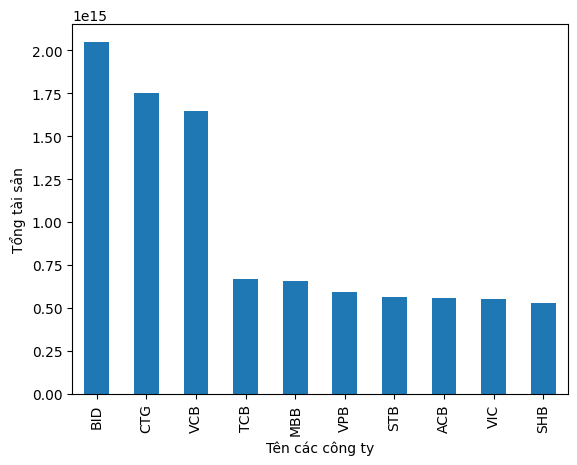

In [52]:
top10_df['totalAssets'].plot.bar(xlabel='Tên các công ty', ylabel='Tổng tài sản')

- Dễ dàng nhận thấy các công ty trên đều là Ngân hàng 